In [1]:
from scipy.integrate import ode
from numpy import cos, sin, pi, linspace, array

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, style
style.use("ggplot")

In [90]:
def generacion_trayectorias_senoidal(t0, t1, n, A, ω):
    from numpy import sin, linspace
    from control import forced_response, tf
    
    f = lambda t: A*sin(ω*t)
    ts = linspace(t0, t1, n)
    us = [f(t) for t in ts]
    
    fso0 = tf([400], [1, 40, 400])
    fso1 = tf([400, 0], [1, 40, 400])
    fso2 = tf([400, 0, 0], [1, 40, 400])
    
    ts, nus, xs = forced_response(fso0, ts, us)
    ts, nu̇s, xs = forced_response(fso1, ts, us)
    ts, nüs, xs = forced_response(fso2, ts, us)
    
    return ts, nus, nu̇s, nüs

In [98]:
def generacion_trayectorias_escalon(t0, t1, n, ref):
    from numpy import sin, linspace
    from control import forced_response, tf
    
    def escalon(t, mag):
        '''
        Esta función toma un vector con el estado del sistema, el tiempo de simulación
        y la magnitud del escalon a simular, y da como resultado el valor de la función
        escalón en el tiempo requerido.
        '''
        if t <= 0:
            y = 0
        else:
            y = mag
        return y
    
    ts = linspace(t0, t1, n)
    us = [escalon(t, ref) for t in ts]
    
    fso0 = tf([400], [1, 40, 400])
    fso1 = tf([400, 0], [1, 40, 400])
    fso2 = tf([400, 0, 0], [1, 40, 400])
    
    ts, nus, xs = forced_response(fso0, ts, us)
    ts, nu̇s, xs = forced_response(fso1, ts, us)
    ts, nüs, xs = forced_response(fso2, ts, us)
    
    return ts, nus, nu̇s, nüs

In [126]:
class pendulo_simple:
    def __init__(self, masa, longitud, inercia, tipo_control, tiempos, trayectorias):
        from numpy import sin, cos, pi, interp
        self.g = 9.81
        self.m = masa
        self.l = longitud
        self.J = inercia
        self.ts = tiempos
        self.qds, self.q̇ds, self.q̈ds = trayectorias
        
        if tipo_control is "nulo":
            self.control = self.control_nulo
            
        if tipo_control is "PD":
            self.control = self.control_PD
            self.kp = 100
            self.kd = 2
            
        if tipo_control is "PD_grav":
            self.control = self.control_PD_grav
            self.kp = 10
            self.kd = 2
            
        if tipo_control is "PD_mas":
            self.control = self.control_PD_mas
            self.kp = 10
            self.kd = 2
            self.λ = self.kp/self.kd
        
    def ec_movimiento(self, t, x):
        q, q̇ = x
        τ = self.control(t, x)
        return [q̇, (τ - self.m*self.g*self.l*cos(q))/(self.m*self.l**2 + self.J)]
    
    def inter_tray(self, t):
        from numpy import interp
        return interp(t, self.ts, self.qds), interp(t, self.ts, self.q̇ds), interp(t, self.ts, self.q̈ds)
    
    def control_nulo(self, t, x):
        return 0
    
    def control_PD(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        return self.kp*(qd - q) + self.kd*(0 - q̇)
    
    def control_PD_grav(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        return self.kp*(qd - q) + self.kd*(0 - q̇) + self.m*self.g*self.l*cos(q)
    
    def control_PD_mas(self, t, x):
        q, q̇ = x
        qd, q̇d, q̈d = self.inter_tray(t)
        m = (self.m*self.l**2 + self.J)
        c = 0
        g = self.m*self.g*self.l*cos(q)
        e, ė = qd - q, q̇d - q̇
        return m*q̈d + c*q̇d + g + (self.kd + m*self.λ)*ė + (self.kp + c*self.λ)*e

In [104]:
t0, tf, x0 = 0, 10, [0, 0]
n = 1000
δt = (tf - t0)/n

ts, us, ups, upps = generacion_trayectorias_escalon(t0, tf, n, 1)

In [105]:
robot1 = pendulo_simple(0.5, 0.4, 0.002, "nulo", ts, [us, ups, upps])

sis1 = ode(robot1.ec_movimiento)
sis1.set_initial_value(x0, t0)

xs1 = [array(x0)]
ts1 = [t0]
for i in range(n):
    xs1.append(sis1.integrate(sis1.t + δt))
    ts1.append(sis1.t)
    
us1 = [robot1.control(t, x) for t, x in zip(ts1, xs1)]
tray1 = [0 for t in ts1]

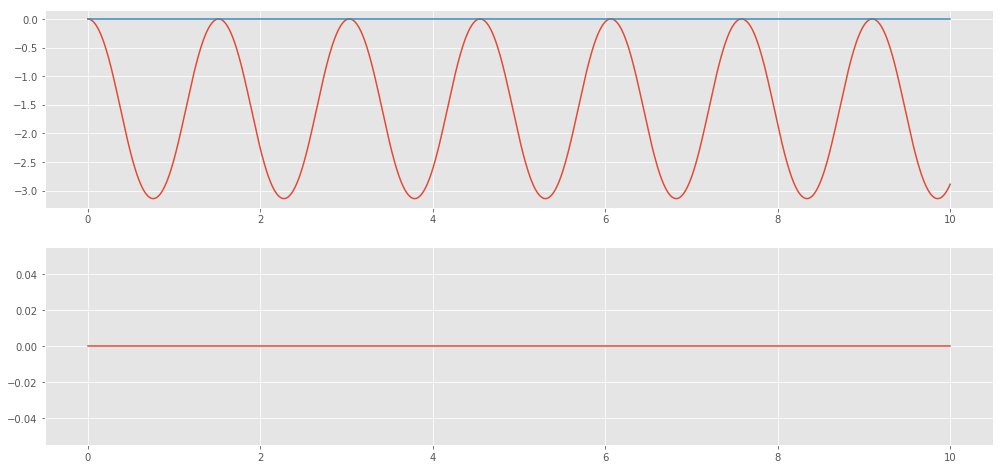

In [106]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts1, array(xs1).T[0])
ax1.plot(ts1, tray1)
ax2.plot(ts1, us1);

In [110]:
ts, tras, traps, trapps = generacion_trayectorias_escalon(t0, tf, n, 1)
robot2 = pendulo_simple(0.5, 0.4, 0.002, "PD", ts, [tras, traps, trapps])

sis2 = ode(robot2.ec_movimiento)
sis2.set_initial_value(x0, t0)

xs2 = [array(x0)]
ts2 = [t0]
for i in range(n):
    xs2.append(sis2.integrate(sis2.t + δt))
    ts2.append(sis2.t)
    
us2 = [robot2.control(t, x) for t, x in zip(ts2, xs2)]
tray2 = tras

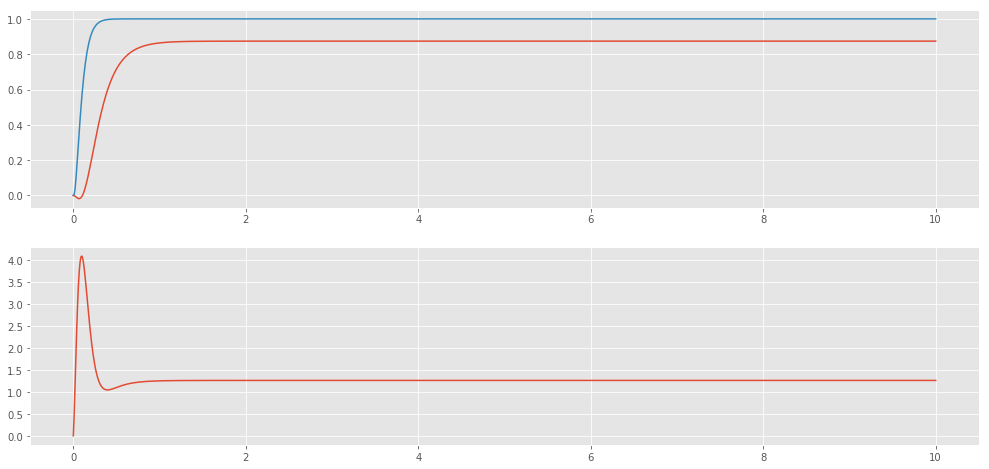

In [112]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts2, array(xs2).T[0])
ax1.plot(ts, tray2)
ax2.plot(ts2, us2);

In [127]:
ts, tras, traps, trapps = generacion_trayectorias_senoidal(t0, tf, n, 1, 2*pi)
robot3 = pendulo_simple(0.5, 0.4, 0.002, "PD", ts, [tras, traps, trapps])

sis3 = ode(robot3.ec_movimiento)
sis3.set_initial_value(x0, t0)

xs3 = [array(x0)]
ts3 = [t0]
for i in range(n):
    xs3.append(sis3.integrate(sis3.t + δt))
    ts3.append(sis3.t)
    
us3 = [robot3.control(t, x) for t, x in zip(ts3, xs3)]

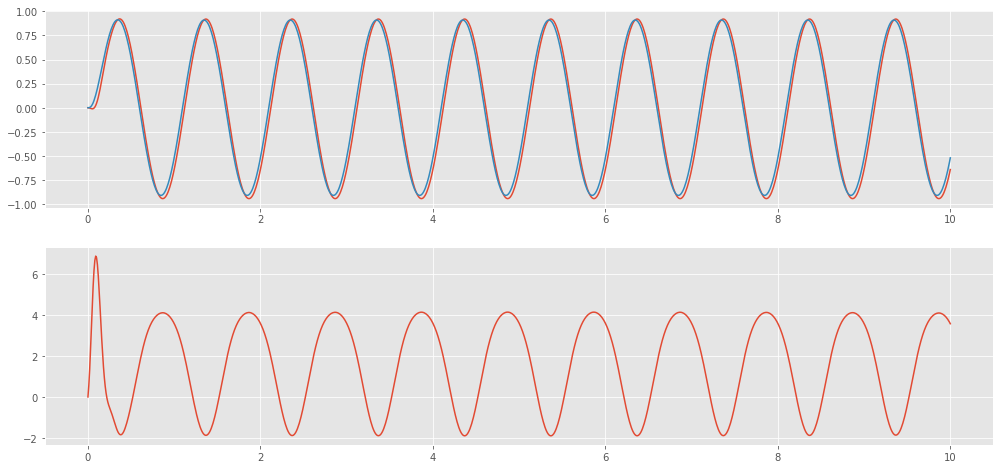

In [128]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts3, array(xs3).T[0])
ax1.plot(ts, tras)
ax2.plot(ts3, us3);

In [115]:
ts, tras, traps, trapps = generacion_trayectorias_escalon(t0, tf, n, 1)
robot4 = pendulo_simple(0.5, 0.4, 0.002, "PD_grav", ts, [tras, traps, trapps])

sis4 = ode(robot4.ec_movimiento)
sis4.set_initial_value(x0, t0)

xs4 = [array(x0)]
ts4 = [t0]
for i in range(n):
    xs4.append(sis4.integrate(sis4.t + δt))
    ts4.append(sis4.t)
    
us4 = [robot4.control(t, x) for t, x in zip(ts4, xs4)]

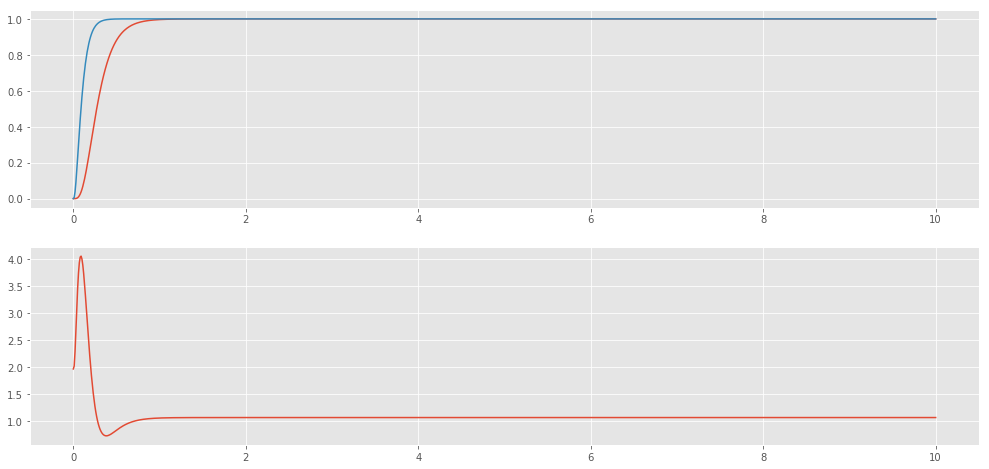

In [116]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts4, array(xs4).T[0])
ax1.plot(ts, tras)
ax2.plot(ts4, us4);

In [117]:
ts, tras, traps, trapps = generacion_trayectorias_senoidal(t0, tf, n, 1, 2*pi)
robot5 = pendulo_simple(0.5, 0.4, 0.002, "PD_grav", ts, [tras, traps, trapps])

sis5 = ode(robot5.ec_movimiento)
sis5.set_initial_value(x0, t0)

xs5 = [array(x0)]
ts5 = [t0]
for i in range(n):
    xs5.append(sis5.integrate(sis5.t + δt))
    ts5.append(sis5.t)
    
us5 = [robot5.control(t, x) for t, x in zip(ts5, xs5)]

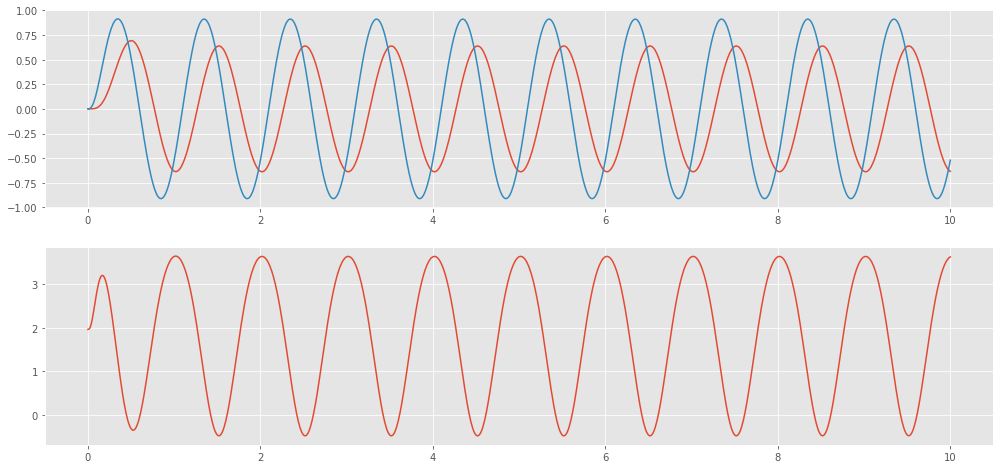

In [118]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts5, array(xs5).T[0])
ax1.plot(ts, tras)
ax2.plot(ts5, us5);

In [121]:
ts, tras, traps, trapps = generacion_trayectorias_senoidal(t0, tf, n, 1, 2*pi)
robot6 = pendulo_simple(0.5, 0.4, 0.002, "PD_mas", ts, [tras, traps, trapps])

sis6 = ode(robot6.ec_movimiento)
sis6.set_initial_value(x0, t0)

xs6 = [array(x0)]
ts6 = [t0]
for i in range(n):
    xs6.append(sis6.integrate(sis6.t + δt))
    ts6.append(sis6.t)
    
us6 = [robot6.control(t, x) for t, x in zip(ts6, xs6)]

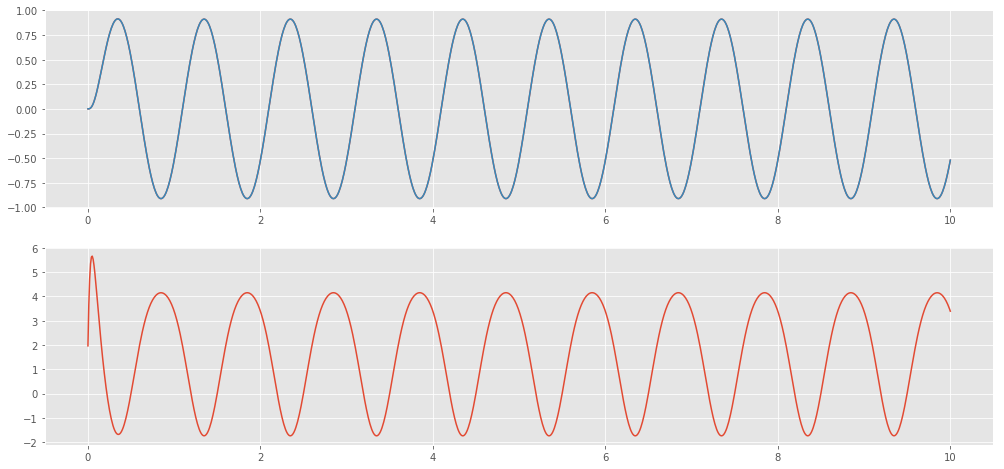

In [122]:
fig = figure(figsize=(17,8))
ax1, ax2 = fig.subplots(2,1)
ax1.plot(ts6, array(xs6).T[0])
ax1.plot(ts, tras)
ax2.plot(ts6, us6);